aiida dataframeをインストール

```
pip install aiida-dataframe
```


In [1]:
from aiida.plugins import DataFactory
import aiida
aiida.load_profile()

Profile<uuid='aaaefae20eac49f892e60b4593a470e3' name='quicksetup'>

In [2]:
from aiida.orm import Code, Int, Dict
from aiida.engine import calcfunction, WorkChain, ToContext
from aiida.plugins.factories import CalculationFactory,WorkflowFactory
import pandas as pd

FrameData = DataFactory('dataframe.frame')

_OUTPUT_DF = False


In [3]:
@calcfunction
def add_x_y(x, y):
    return x + y


class PositiveIntAddWorkChain(WorkChain):
    """WorkChain to multiply two numbers and add a third, for testing and demonstration purposes."""

    @classmethod
    def define(cls, spec):
        """Specify inputs and outputs."""
        super().define(spec)
        spec.input('x', valid_type=Int)
        spec.input('y', valid_type=Int)
        spec.input('params', valid_type=Dict, required=False) 
        # paramsは使っていないが、入力ポートをRestartWorkChainと合わせるために必要
        
        spec.outline(
            cls.add,
            cls.validate_results,
            cls.result,
        )
        spec.output('result', valid_type=Int)
        if _OUTPUT_DF:
            spec.output('history', valid_type=FrameData)
        # define exit code used in this class.
        # It will be accessed by self.exit_codes.ERROR_NEGATIVE_NUMBER.
        spec.exit_code(400, 'ERROR_NEGATIVE_NUMBER', message='The result is a negative number.')

        
    def validate_results(self):
        """Make sure the result is not negative."""
        print("validate_results", self.ctx.sum)
        self.out('result', self.ctx.sum)
        if self.ctx.sum <= 0:
            print("error", self.exit_codes.ERROR_NEGATIVE_NUMBER)
            return self.exit_codes.ERROR_NEGATIVE_NUMBER
        
    def add(self):
        """Multiply two integers. returns x*y"""
        self.ctx.sum = add_x_y(self.inputs.x, self.inputs.y)

    def result(self):
        """Add the result to the outputs."""
        self.out('result', self.ctx.sum)
        if _OUTPUT_DF:
            df = pd.DataFrame([[1,2,3],[3,34,5]], columns=['a','b','c'])
            self.out('history', FrameData(df).store())     

In [4]:
addworkchain = PositiveIntAddWorkChain
from aiida.engine import run, submit
params = {"incx": Int(1), "incy": Int(2)}
results, node = run.get_node(addworkchain, x=Int(2), y=Int(5))
results, node

validate_results uuid: 9382b76d-4215-4e68-ad8a-c4ee40cff6dd (pk: 11695) value: 7


({'result': <Int: uuid: 9382b76d-4215-4e68-ad8a-c4ee40cff6dd (pk: 11695) value: 7>},
 <WorkChainNode: uuid: dc266f67-8d89-49c7-802c-76b37a526dec (pk: 11693) (__main__.PositiveIntAddWorkChain)>)

# errorを起こす。

In [6]:
caddworkchain, x=Int(2), y=Int(-5))
print(results, node)
# エラーコードを取得
from icecream import ic
exit_status = node.exit_status
exit_message = node.exit_message
ic(exit_status, exit_message)
if exit_status:  # エラーが存在するか確認
    print(f"エラーが発生しました: {exit_message} (ステータスコード: {exit_status})")
else:
    print(f"結果: {results['result']}")

validate_results uuid: 17517a48-6b5e-402a-a323-ddb045c0f0f8 (pk: 11705) value: -3
error ExitCode(status=400, message='The result is a negative number.', invalidates_cache=False)
{'result': <Int: uuid: 17517a48-6b5e-402a-a323-ddb045c0f0f8 (pk: 11705) value: -3>} uuid: 28deb3df-02f6-44b5-acf1-c48e9af9391a (pk: 11703) (__main__.PositiveIntAddWorkChain)


ic| exit_status: 400, exit_message: 'The result is a negative number.'


エラーが発生しました: The result is a negative number. (ステータスコード: 400)


# error handling

上のコードはx+y <=0だとエラー止まっていた。

次のコードはエラーが起きるたびに
x+incx, y+incy 
を行い、PositiveIntAddWorkChainを呼び出す。

動作は
(-2,-4) -> (-2+1->-1, -4+2->-2) -> (-1+1->0, -2+2->0) -> (-0+1->1, 0+2->2)
となる。

In [7]:
from aiida.engine import BaseRestartWorkChain
from aiida.plugins import CalculationFactory
from aiida import orm
from aiida.engine import while_
from aiida.engine import process_handler, ProcessHandlerReport
from aiida.engine import run


class AddCorrectionBaseWorkChain(BaseRestartWorkChain):

    _process_class = PositiveIntAddWorkChain
    
    @classmethod
    def define(cls, spec):
        """Define the process specification."""
        super().define(spec)
        
        spec.expose_inputs(cls._process_class)
        spec.expose_outputs(cls._process_class)

        
        spec.outline(
            cls.setup,
            while_(cls.should_run_process)(
                cls.run_process,
                cls.inspect_process,
            ),
            cls.results,
        )
        spec.exit_code(500, 'ERROR_NO_RECOVERY', message='The product is a negative number.')
        
    def setup(self):
        """Call the `setup` of the `BaseRestartWorkChain` and then create the inputs dictionary in `self.ctx.inputs`.

        This `self.ctx.inputs` dictionary will be used by the `BaseRestartWorkChain` to submit the process in the
        internal loop.
        """
        super().setup()
        self.ctx.inputs = {'x': self.inputs.x, 'y': self.inputs.y, 'params': self.inputs.params}

    @process_handler(priority=500, exit_codes=_process_class.exit_codes.ERROR_NEGATIVE_NUMBER)
    def handle_negative_result(self, node):
        """Check if the calculation failed with `ERROR_X_NEGATIVE_NUMBER`.

        If this is the case, simply make the inputs positive by taking the absolute value.

        :param node: the node of the subprocess that was ran in the current iteration.
        :return: optional :class:`~aiida.engine.processes.workchains.utils.ProcessHandlerReport` instance to signal
            that a problem was detected and potentially handled.
        """
        print("result negative")
        if node.exit_status == self._process_class.exit_codes.ERROR_NEGATIVE_NUMBER.status:
            incy = node.inputs.params.get_dict()["incy"]
            incx = node.inputs.params.get_dict()["incx"]
            # outputも見える。
            print("output.result", node.outputs, node.outputs.result)
            print("node", node)
            # print("ctx.sum", node.ctx.sum) # node.ctxは見えない。
            # 見えるのはnode.inputs, node.outputs
            self.ctx.inputs['x'] = Int(node.inputs.x.value+incx)
            self.ctx.inputs['y'] = Int(node.inputs.y.value+incy)
            print("add x,y",incx, incy)
            print("change x,y", self.ctx.inputs['x'].value, self.ctx.inputs['y'].value)
            return ProcessHandlerReport()   
        
        return ProcessHandlerReport(exit_code=self.exit_codes.ERROR_NO_RECOVERY)


## 要点

1. 一度self.ctx.inputsに入れてから、元のworkchainを実行する。
2. 再実行が必要な場合はエラーとするようコードをカオス。
3. エラーの場合はself.ctx.inputsに再実行のための入力を入れてから元のworkchainの再実行を行う。

- (1) self.inputs  -> (2) self.ctx.inputs -> (3) 元のworkchainを実行 -> (4) 失敗した場合 -> (5) 再実行するための更新されて入力をself.ctx.inputsに入れて(3)に戻る。
- (3) 実行 で成功した場合は元のworkchainを実行 の結果を返す。


最大回数はmax_iterationsで指定できます。

In [8]:
restartaddworkchain = AddCorrectionBaseWorkChain
results, node = run.get_node(restartaddworkchain, x=Int(-2), y=Int(-4), 
             max_iterations= Int(10),
             params=Dict(dict=params)
             )
results, node

12/05/2024 03:06:10 PM <4982> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11711|AddCorrectionBaseWorkChain|run_process]: launching PositiveIntAddWorkChain<11712> iteration #1


validate_results uuid: 47ba160d-8498-4c59-8058-4be0768ef291 (pk: 11714) value: -6
error ExitCode(status=400, message='The result is a negative number.', invalidates_cache=False)
result negative
output.result Manager for outgoing RETURN links for node pk=11712 uuid: 47ba160d-8498-4c59-8058-4be0768ef291 (pk: 11714) value: -6
node uuid: 72ce0c60-b618-416f-b359-692fd15e8924 (pk: 11712) (__main__.PositiveIntAddWorkChain)
add x,y 1 2
change x,y -1 -2


12/05/2024 03:06:11 PM <4982> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11711|AddCorrectionBaseWorkChain|inspect_process]: PositiveIntAddWorkChain<11712> failed but a handler dealt with the problem, restarting
12/05/2024 03:06:11 PM <4982> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11711|AddCorrectionBaseWorkChain|run_process]: launching PositiveIntAddWorkChain<11717> iteration #2


validate_results uuid: dc3d45a8-2ffd-4af0-88bc-9099086c992a (pk: 11719) value: -3
error ExitCode(status=400, message='The result is a negative number.', invalidates_cache=False)
result negative
output.result Manager for outgoing RETURN links for node pk=11717 

12/05/2024 03:06:12 PM <4982> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11711|AddCorrectionBaseWorkChain|inspect_process]: PositiveIntAddWorkChain<11717> failed but a handler dealt with the problem, restarting


uuid: dc3d45a8-2ffd-4af0-88bc-9099086c992a (pk: 11719) value: -3
node uuid: 6dd9dbcc-e1ff-4b24-bc3b-7784e09e4bdf (pk: 11717) (__main__.PositiveIntAddWorkChain)
add x,y 1 2
change x,y 0 0


12/05/2024 03:06:12 PM <4982> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11711|AddCorrectionBaseWorkChain|run_process]: launching PositiveIntAddWorkChain<11722> iteration #3


validate_results uuid: ebc50a59-47fc-48b0-9753-8257596f5051 (pk: 11724) value: 0
error ExitCode(status=400, message='The result is a negative number.', invalidates_cache=False)
result negative
output.result Manager for outgoing RETURN links for node pk=11722 uuid: ebc50a59-47fc-48b0-9753-8257596f5051 (pk: 11724) value: 0
node uuid: ad78e7bd-00c2-444f-bcfe-7b5a2a03fe85 (pk: 11722) (__main__.PositiveIntAddWorkChain)
add x,y 1 2
change x,y 1 2


12/05/2024 03:06:13 PM <4982> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11711|AddCorrectionBaseWorkChain|inspect_process]: PositiveIntAddWorkChain<11722> failed but a handler dealt with the problem, restarting
12/05/2024 03:06:13 PM <4982> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11711|AddCorrectionBaseWorkChain|run_process]: launching PositiveIntAddWorkChain<11727> iteration #4


validate_results uuid: ede75430-cf0f-4ca7-bd40-dbb965d18335 (pk: 11729) value: 3


12/05/2024 03:06:14 PM <4982> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11711|AddCorrectionBaseWorkChain|results]: work chain completed after 4 iterations
12/05/2024 03:06:14 PM <4982> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [11711|AddCorrectionBaseWorkChain|on_terminated]: remote folders will not be cleaned


({'result': <Int: uuid: ede75430-cf0f-4ca7-bd40-dbb965d18335 (pk: 11729) value: 3>},
 <WorkChainNode: uuid: a26891ab-aa56-43a4-9423-99813780ecbd (pk: 11711) (__main__.AddCorrectionBaseWorkChain)>)

In [10]:
from aiida.orm import load_node
pk = node.pk
node = load_node(pk)
node

<WorkChainNode: uuid: a26891ab-aa56-43a4-9423-99813780ecbd (pk: 11711) (__main__.AddCorrectionBaseWorkChain)>

Success: Output written to `11711.dot.pdf`


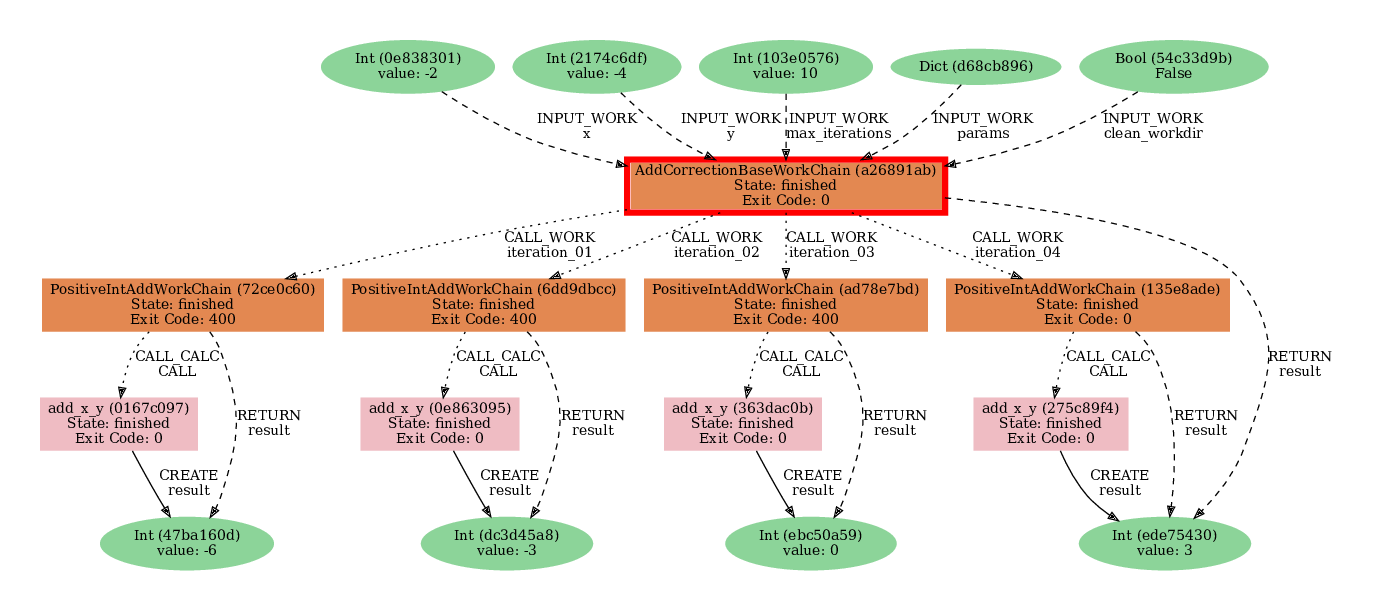

In [11]:
import subprocess
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))